## MIMIC-3 Analysis: Bayesian Networks, Model Evaluation, Manual SCM

With our SCM's, which do not appear robust, we will develop and test Bayesian networks. We will also do the same for a manually created SCM.

## Configuration

These cells remain the same as last week.

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/Week 11

In [0]:
# Need to restart runtime following this install
! pip install causalnex
! pip install --upgrade pandas==0.24.0  # We require this version of pandas

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
files.upload()

In [0]:
import pandas as pd
df = pd.read_csv('mimic_day_blocks_ARDS2.csv', delimiter=',')

In [0]:
import numpy as np
df_enc = df.copy()

non_numeric_columns = ['GENDER', 'AGE_INTERVALS']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_enc[col] = le.fit_transform(df_enc[col])

## Feature Engineering, Imputation

These cells also remain the same as last week.

In [0]:
import numpy as np
df_enc = df.copy()

# Encode discrete variables
non_numeric_columns = ['GENDER', 'AGE_INTERVALS']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_enc[col] = le.fit_transform(df_enc[col])

# Create additional features
df_enc['Driving_Pressure'] = df_enc['Plateau_Pressure_cmH2O'] - \
  df_enc['Total_PEEP_cmH2O']
df_enc['Tidal_ml/BMI'] = df_enc['Tidal_ml']/df_enc['BMI']
df_enc['Driving_Pressure/BMI'] = df_enc['Driving_Pressure']/df_enc['BMI']

# Remove obsolete features
drops = ['PaO2', 'FiO2', 'Tidal_ml', 'Plateau_Pressure_cmH2O', \
  'Total_PEEP_cmH2O', 'AGE_INTERVALS']
df_enc = df_enc.drop(columns=drops)

In [0]:
def add_series_list(col_list, df=df_e):
  # Find the time series for a list of parameters and add to df_e
  for col in col_list:
    df[col + ' Change'] = find_series(col)

  return df.dropna()

In [0]:
def find_series(col, df=df_e):
  # Find daily flux in a given parameter
  diff_col = np.zeros(len(df[col]))
  diff_col[0] = np.nan
  diff_col = pd.Series(diff_col)
  

  for i in range(len(diff_col)-1, -1, -1):

    if i != 0:

      if df['HADM_ID'][i] == df['HADM_ID'][i-1]:
        diff_col[i] = np.abs(df[col][i] - df[col][i-1])

      else:
        diff_col[i] = np.nan

  return diff_col

In [0]:
 def impute(df_e):
  # Replace infinities with nan
  df_e.replace([-np.inf, np.inf], np.nan, inplace=True)

  # Do not remove zeroes from discrete variables
  cols_disc = ['HADM_ID', 'CHARTDATE', 'ARDS', 'GENDER', 'AGE_INTERVALS']
  cols_cont = [i for i in df_e.columns if i not in cols_disc]

  from sklearn.preprocessing import scale

  # Replace outliers 3 standard devs or more away with nan, scale cont vars
  for col in cols_cont:
    df_e[col] = df_e[col].mask(df_e[col].values - df_e[col].mean() > \
      3*df_e[col].std(), other=np.nan)
    df_e[col] = scale(df_e[col])

  # Impute all nan with K clustering, not on variables that don't make sense
  from sklearn.impute import KNNImputer

  # Remove, store irrelevant columns
  store_vars = ['HADM_ID', 'CHARTDATE']
  store_inds = [df_e.columns.get_loc(i) for i in store_vars]
  df_store = df_e[store_vars]
  df_e = df_e.drop(columns=store_vars)

  # Copy df_e to check how many values are imputed
  df_check = df_e.copy()

  # Store parameter labels of df_e
  my_columns = df_e.columns

  # Impute over relevant columns
  imp = KNNImputer(missing_values=np.nan)
  df_e = pd.DataFrame(imp.fit_transform(df_e), columns=my_columns)

  # Count imputations
  num_imp = df_check.size - np.sum(np.sum(df_e.values==df_check.values))

  # Restore irrelevant columns in original order for ease of viewing
  for i in range(len(store_vars)):
    df_e.insert(store_inds[i], store_vars[i], df_store[store_vars[i]])

  return df_e

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2', \
  'Driving_Pressure', 'Tidal_ml/BMI', 'Driving_Pressure/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

## SCM's

In [0]:
! apt-get install -y graphviz-dev  # We require the developer version
! pip install pygraphviz

In [0]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas

% LATEX BEGINNING

We begin exploring our dataset by developing SCM's excluding temporal parameters. From here on in we forbid all source nodes, \url{GENDER}, \url{AGE}, from being children of any other node and will delete trivial relations between created parameters and their components such as \url{Driving_Pressure/BMI} $\rightarrow$ \url{Driving_Pressure} and \url{Driving_Pressure} $\rightarrow$ \url{RSC}. Additionally we ban \url{ARDS} from being a parent of any other node.

% LATEX END

In [0]:
df_e = df_enc.copy()

df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

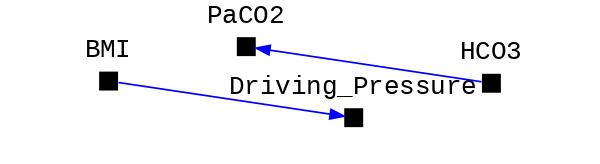

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
# We know that these are isolates or undesirable so remove them for viewing
sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'ARDS', 'AGE', 'GENDER',
  'Creatinine', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

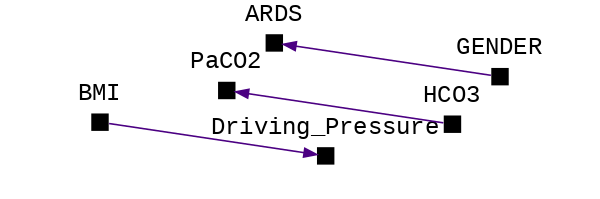

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Creatinine', \
  'Driving_Pressure/BMI', 'Tidal_ml/BMI'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'indigo'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

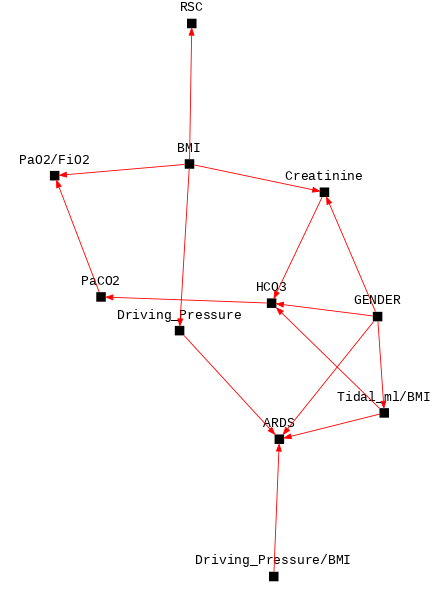

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.1)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure/BMI', 'RSC')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['AGE'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'red'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

We see that without temporal parameters our structure is not robust. Accordingly we introduce them, now also forbidding trivial edges such as \url{HCO3_Change} $\rightarrow$ \url{HCO3}.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

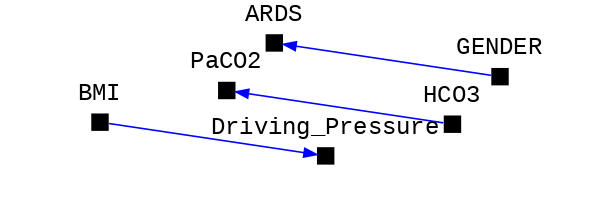

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change', 'Creatinine', 'Creatinine Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

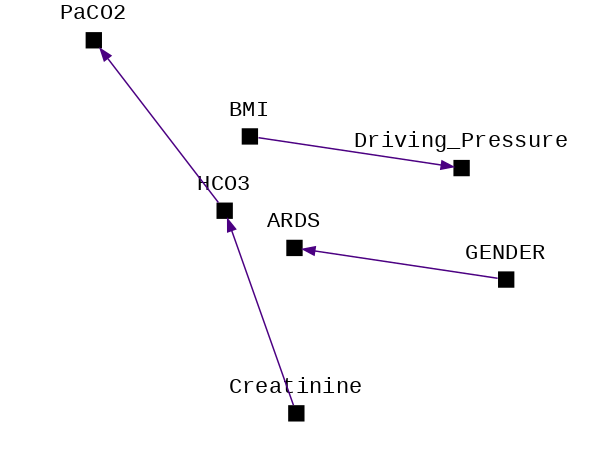

In [35]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change', 'Creatinine Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'indigo'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Once again our structure does not appear robust; this time we try changing our temporal parameters to absolute daily differences to see if we can find a strong SCM.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

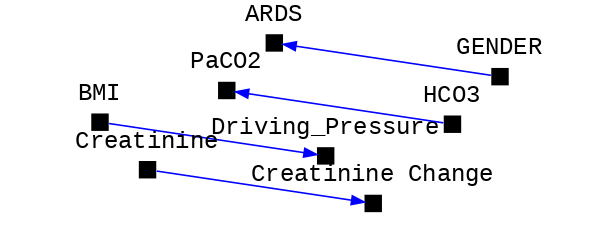

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

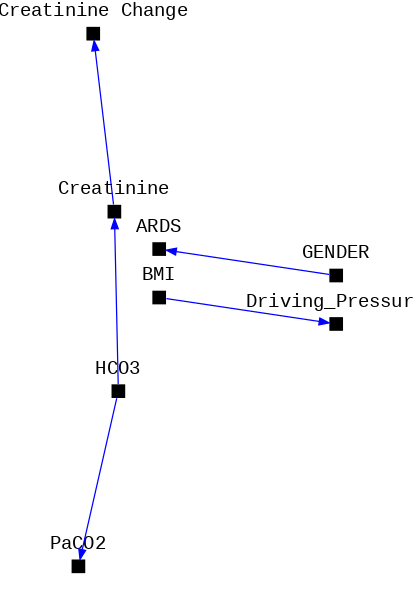

In [0]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.2)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

## BN's

For both the original and absolute time series we take the first model to return a SCM with more than just isolated edges. First we try the original time series. There are a lot of results here so we will cover them separately, especially given most results are similar.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

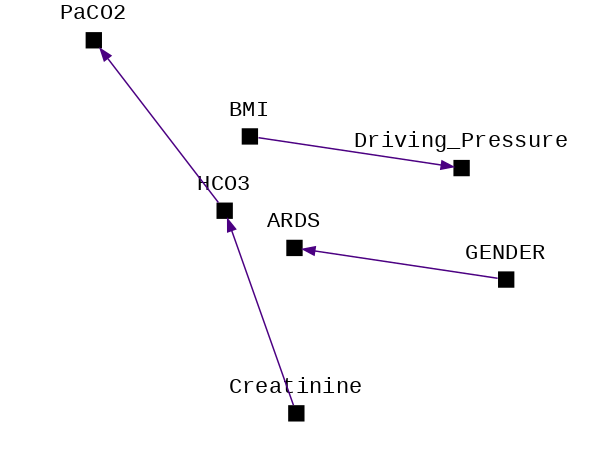

In [101]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change', 'Creatinine Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'indigo'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In [0]:
from causalnex.discretiser import Discretiser
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report
from causalnex.evaluation import roc_auc
import matplotlib.pyplot as plt

In [0]:
rem_list = list(sm_t.nodes)
df_e_disc = df_e[rem_list]

for col in df_e_disc:
  df_e_disc[col] = Discretiser(method='quantile', \
  num_buckets=5).fit_transform(df_e_disc[col].values)

  my_map = {}

  for i in range(0, 5):
    my_map[i] = col + '_' + str(i+1)

  df_e_disc[col] = df_e_disc[col].map(my_map)

We note our \``random_state=7`\` (random seed).

In [0]:
train, test = train_test_split(df_e_disc, train_size=0.9, \
  test_size=0.1, random_state=7)

sm_t = sm_t.get_largest_subgraph()
bn = BayesianNetwork(sm_t)
bn = bn.fit_node_states(df_e_disc)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [34]:
classification_report(bn, test, 'PaCO2')

{'PaCO2_PaCO2_1': {'f1-score': 0.337984496124031,
  'precision': 0.20335820895522388,
  'recall': 1.0,
  'support': 109},
 'PaCO2_PaCO2_2': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 98},
 'PaCO2_PaCO2_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 112},
 'PaCO2_PaCO2_4': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 91},
 'PaCO2_PaCO2_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 126},
 'accuracy': 0.20335820895522388,
 'macro avg': {'f1-score': 0.06759689922480619,
  'precision': 0.04067164179104478,
  'recall': 0.2,
  'support': 536},
 'weighted avg': {'f1-score': 0.06873192178641675,
  'precision': 0.0413545611494765,
  'recall': 0.20335820895522388,
  'support': 536}}

In [40]:
roc, auc = roc_auc(bn, test, 'PaCO2')
x_diffs_PaCO2 = [roc[i][0] for i in range(len(roc))]
y_diffs_PaCO2 = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5


In [103]:
classification_report(bn, test, 'HCO3')

{'HCO3_HCO3_1': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 106},
 'HCO3_HCO3_2': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 78},
 'HCO3_HCO3_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 87},
 'HCO3_HCO3_4': {'f1-score': 0.4441219158200291,
  'precision': 0.28544776119402987,
  'recall': 1.0,
  'support': 153},
 'HCO3_HCO3_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 112},
 'accuracy': 0.28544776119402987,
 'macro avg': {'f1-score': 0.08882438316400582,
  'precision': 0.05708955223880598,
  'recall': 0.2,
  'support': 536},
 'weighted avg': {'f1-score': 0.1267736065680307,
  'precision': 0.08148042437068391,
  'recall': 0.28544776119402987,
  'support': 536}}

In [41]:
roc, auc = roc_auc(bn, test, 'HCO3')
x_diffs_HCO3 = [roc[i][0] for i in range(len(roc))]
y_diffs_HCO3 = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5


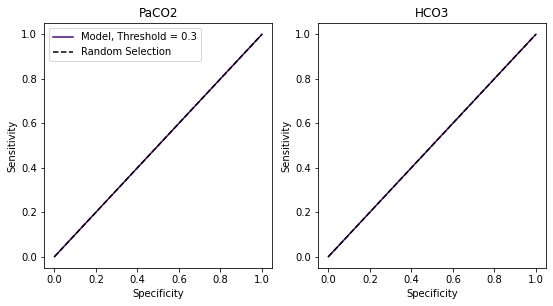

In [108]:
fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))

x_rand = np.linspace(0, 1)
y_rand = x_rand

ax_l.plot(x_diffs_PaCO2, y_diffs_PaCO2, color='indigo', \
  label='Model, Threshold = 0.3')
ax_l.plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
ax_l.set_xlabel('Specificity')
ax_l.set_ylabel('Sensitivity')
ax_l.set_title('PaCO2')

ax_r.plot(x_diffs_HCO3, y_diffs_HCO3, color='indigo', \
  label='Model, Threshold = 0.3')
ax_r.plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
ax_r.set_xlabel('Specificity')
ax_r.set_ylabel('Sensitivity')
ax_r.set_title('HCO3')

ax_l.legend()
plt.show()

Seeing that our model is not useful, we try the absolute time series.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

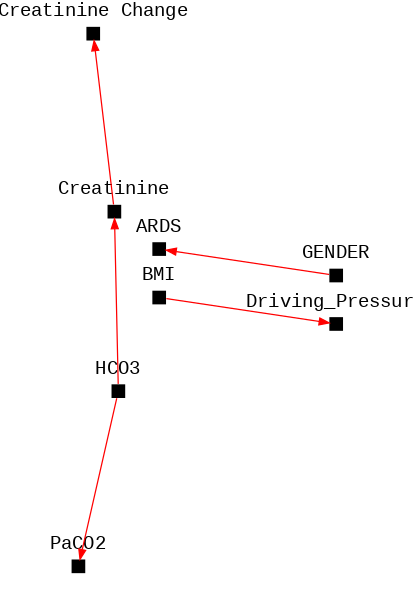

In [121]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.2)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'red'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

In [0]:
rem_list = list(sm_t.nodes)
df_e_disc = df_e[rem_list]

for col in df_e_disc:
  df_e_disc[col] = Discretiser(method='quantile', \
  num_buckets=5).fit_transform(df_e_disc[col].values)

  my_map = {}

  for i in range(0, 5):
    my_map[i] = col + '_' + str(i+1)

  df_e_disc[col] = df_e_disc[col].map(my_map)

In [0]:
train, test = train_test_split(df_e_disc, train_size=0.9, \
  test_size=0.1, random_state=7)

sm_t = sm_t.get_largest_subgraph()
bn = BayesianNetwork(sm_t)
bn = bn.fit_node_states(df_e_disc)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [124]:
classification_report(bn, test, 'PaCO2')

{'PaCO2_PaCO2_1': {'f1-score': 0.337984496124031,
  'precision': 0.20335820895522388,
  'recall': 1.0,
  'support': 109},
 'PaCO2_PaCO2_2': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 98},
 'PaCO2_PaCO2_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 112},
 'PaCO2_PaCO2_4': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 91},
 'PaCO2_PaCO2_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 126},
 'accuracy': 0.20335820895522388,
 'macro avg': {'f1-score': 0.06759689922480619,
  'precision': 0.04067164179104478,
  'recall': 0.2,
  'support': 536},
 'weighted avg': {'f1-score': 0.06873192178641675,
  'precision': 0.0413545611494765,
  'recall': 0.20335820895522388,
  'support': 536}}

In [74]:
roc, auc = roc_auc(bn, test, 'PaCO2')
x_abs_PaCO2 = [roc[i][0] for i in range(len(roc))]
y_abs_PaCO2 = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5


In [125]:
classification_report(bn, test, 'Creatinine')

{'Creatinine_Creatinine_1': {'f1-score': 0.28205128205128205,
  'precision': 0.16417910447761194,
  'recall': 1.0,
  'support': 88},
 'Creatinine_Creatinine_2': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 104},
 'Creatinine_Creatinine_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 133},
 'Creatinine_Creatinine_4': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 106},
 'Creatinine_Creatinine_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 105},
 'accuracy': 0.16417910447761194,
 'macro avg': {'f1-score': 0.05641025641025641,
  'precision': 0.03283582089552239,
  'recall': 0.2,
  'support': 536},
 'weighted avg': {'f1-score': 0.04630692690394183,
  'precision': 0.026954778347070617,
  'recall': 0.16417910447761194,
  'support': 536}}

In [75]:
roc, auc = roc_auc(bn, test, 'Creatinine')
x_abs_Creatinine = [roc[i][0] for i in range(len(roc))]
y_abs_Creatinine = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5


In [127]:
classification_report(bn, test, 'Creatinine Change')

{'Creatinine Change_Creatinine Change_2': {'f1-score': 0.5744680851063829,
  'precision': 0.40298507462686567,
  'recall': 1.0,
  'support': 216},
 'Creatinine Change_Creatinine Change_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 68},
 'Creatinine Change_Creatinine Change_4': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 129},
 'Creatinine Change_Creatinine Change_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 123},
 'accuracy': 0.40298507462686567,
 'macro avg': {'f1-score': 0.14361702127659573,
  'precision': 0.10074626865671642,
  'recall': 0.25,
  'support': 536},
 'weighted avg': {'f1-score': 0.23150206414734834,
  'precision': 0.1623969703720205,
  'recall': 0.40298507462686567,
  'support': 536}}

In [77]:
roc, auc = roc_auc(bn, test, 'Creatinine Change')
x_abs_Creatinine_Change = [roc[i][0] for i in range(len(roc))]
y_abs_Creatinine_Change = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5


In [128]:
classification_report(bn, test, 'HCO3')

{'HCO3_HCO3_1': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 106},
 'HCO3_HCO3_2': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 78},
 'HCO3_HCO3_3': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 87},
 'HCO3_HCO3_4': {'f1-score': 0.4441219158200291,
  'precision': 0.28544776119402987,
  'recall': 1.0,
  'support': 153},
 'HCO3_HCO3_5': {'f1-score': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'support': 112},
 'accuracy': 0.28544776119402987,
 'macro avg': {'f1-score': 0.08882438316400582,
  'precision': 0.05708955223880598,
  'recall': 0.2,
  'support': 536},
 'weighted avg': {'f1-score': 0.1267736065680307,
  'precision': 0.08148042437068391,
  'recall': 0.28544776119402987,
  'support': 536}}

In [78]:
roc, auc = roc_auc(bn, test, 'HCO3')
x_abs_HCO3 = [roc[i][0] for i in range(len(roc))]
y_abs_HCO3 = [roc[i][1] for i in range(len(roc))]
print(auc)

0.5643656716417911


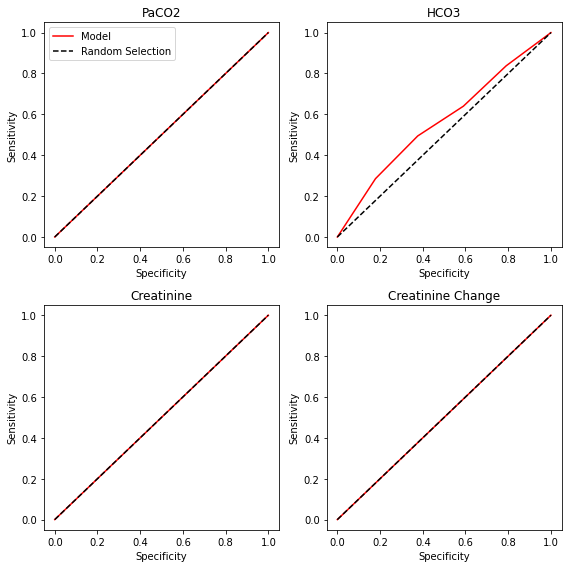

In [89]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

x_rand = np.linspace(0, 1)
y_rand = x_rand

axs[0, 0].plot(x_abs_PaCO2, y_abs_PaCO2, color='red', \
  label='Model')
axs[0, 0].plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
axs[0, 0].set_xlabel('Specificity')
axs[0, 0].set_ylabel('Sensitivity')
axs[0, 0].set_title('PaCO2')

axs[0, 1].plot(x_abs_HCO3, y_abs_HCO3, color='red', \
  label='Model')
axs[0, 1].plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
axs[0, 1].set_xlabel('Specificity')
axs[0, 1].set_ylabel('Sensitivity')
axs[0, 1].set_title('HCO3')

axs[1, 0].plot(x_abs_Creatinine, y_abs_Creatinine, color='red', \
  label='Model')
axs[1, 0].plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
axs[1, 0].set_xlabel('Specificity')
axs[1, 0].set_ylabel('Sensitivity')
axs[1, 0].set_title('Creatinine')

axs[1, 1].plot(x_abs_Creatinine_Change, y_abs_Creatinine_Change, color='red', \
  label='Model')
axs[1, 1].plot(x_rand, y_rand, linestyle='--', color='k', label='Random Selection')
axs[1, 1].set_xlabel('Specificity')
axs[1, 1].set_ylabel('Sensitivity')
axs[1, 1].set_title('Creatinine Change')

axs[0, 0].legend()
plt.tight_layout()
plt.show()

As suspected, our model is not robust although we note we can actually predict something for HCO3 (a collider) with this model.

## Manual SCM, Bayesian Network

None of our models so far have been able to meaningfully predict for ARDS, so we create an SCM manually to see what we can find.

In [0]:
from causalnex.structure import StructureModel

In [0]:
sm_t = StructureModel()

sm_t.add_edges_from([
    ('GENDER', 'RSC'),
    ('BMI', 'RSC'),
    ('Driving_Pressure', 'RSC'),
    ('RSC', 'ARDS')
])

In [0]:
rem_list = list(sm_t.nodes)
df_e_disc = df_e[rem_list]

for col in df_e_disc:
  df_e_disc[col] = Discretiser(method='quantile', \
  num_buckets=5).fit_transform(df_e_disc[col].values)

  my_map = {}

  for i in range(0, 5):
    my_map[i] = col + '_' + str(i+1)

  df_e_disc[col] = df_e_disc[col].map(my_map)

In [0]:
train, test = train_test_split(df_e_disc, train_size=0.9, \
  test_size=0.1, random_state=7)

sm_t = sm_t.get_largest_subgraph()
bn = BayesianNetwork(sm_t)
bn = bn.fit_node_states(df_e_disc)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

0.5


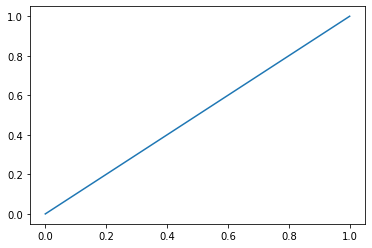

In [148]:
roc, auc = roc_auc(bn, test, 'ARDS')
x_man_ARDS = [roc[i][0] for i in range(len(roc))]
y_man_ARDS = [roc[i][1] for i in range(len(roc))]
print(auc)

plt.plot(x_man_ARDS, y_man_ARDS)
plt.show()

We see things are similarly not useful but may consider other manual models.